In [2]:
import numpy as np
from glob import glob
import cv2 as cv
import os 
from os.path import join,basename
from natsort import natsorted 
import random
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [2]:
seq_len=64

In [1]:
paths={'saved_dire':join('datasets_features','smarthome','rgb','raw_img','CS','train'),
'rgb_raw':join('raw_dataset','CS','train'),
'json_path':join('datasets_features','smarthome','new_pose','CS','train')

}

NameError: name 'join' is not defined

In [4]:
def get_json_dire(video_dire):
    json_name=os.path.basename(video_dire)[:-4]+'_pose3d.json'
    class_name=json_name.split('_')[0]
    json_dire=join(paths['json_path'],class_name,json_name)
    return json_dire


In [5]:
def get_bbox_info(json_dire):
    with open(json_dire) as f:
        data=json.load(f)

    non_empty_frames=[]

    for frame_num,i in enumerate(data['frames']):
        
        if len(i)!=0:
            non_empty_frames.append(frame_num)

    bbox_frames=[0]*len(non_empty_frames)

    for i,frame_num in enumerate(non_empty_frames):
        pose2d=np.array(data['frames'][frame_num][0]['pose2d']).reshape(13,2)
        x=int(min(pose2d[:,0]))
        w=int(max(pose2d[:,0]))-int(min(pose2d[:,0]))
        y=int(min(pose2d[:,1]))-3
        h=int(max(pose2d[:,1]))-int(min(pose2d[:,1]))+3
        bbox=[x,y,w,h]
        
        bbox_frames[i]=bbox
    
    bbox_info=dict(zip(non_empty_frames,bbox_frames))
    bbox_info=dict([i for i in bbox_info.items() if min(i[1])>=0 ])
    
    return bbox_info



In [6]:
def crop_img(frame,bbox,h_req,w_req):
    x,y,w,h=bbox
    
    
    if h >= h_req:
        
        diff_h=int((h-h_req)/2)
        
        y=int(y+diff_h)
        y1=y+h_req


        while y >frame.shape[0]:
            height_diff=y-frame.shape[0]
            if height_diff==1:
                y1=y1-height_diff
                y=y-height_diff
            else:
                height_diff=int(np.floor((y-frame.shape[0])/2))
                y1=y1-height_diff
                y=y-height_diff
        
        
            
        #Adjusting if crop boundry goes out of frame (y1> original height)
        while y1 >frame.shape[0]:
            height_diff=y1-frame.shape[0]
            if height_diff==1:
                y1=y1-height_diff
                y=y-height_diff
            else:
                height_diff=int(np.floor((y1-frame.shape[0])/2))
                y1=y1-height_diff
                y=y-height_diff
        

    else:
        diff_h=int((h_req-h)/2)
        y=int(y-diff_h)
        y1=y+h_req
    
        # Adjusting if y1 becomes negative
        while y <0:
            height_diff=frame.shape[0]-y1
            if height_diff==1:
                y1=y1+height_diff
                y=y+height_diff
                
            else:
                height_diff=int(np.floor((frame.shape[0]-y1)/2))
                y1=y1+height_diff
                y=y+height_diff
            
        #Adjusting if crop boundry goes out of frame (y1> original height)
        while y1 >frame.shape[0]:
            height_diff=y1-frame.shape[0]
            if height_diff==1:
                y1=y1-height_diff
                y=y-height_diff
            else:
                height_diff=int(np.floor((y1-frame.shape[0])/2))
                y1=y1-height_diff
                y=y-height_diff    

    if w >= w_req:
        
        diff_h=int((w-w_req)/2)
        
        x=w+diff_h
        x1=x+w_req

        
        while x >frame.shape[1]:
            w_diff=x-frame.shape[1]
            if w_diff==1:
                x1=x1-w_diff
                x=x-w_diff
            else:
                w_diff=int(np.floor((x-frame.shape[1])/2))
                x1=x1-w_diff
                x=x-w_diff


        
        while x1 >frame.shape[1]:
            w_diff=x1-frame.shape[1]
            if w_diff==1:
                x1=x1-w_diff
                x=x-w_diff
            else:
                w_diff=int(np.floor((x1-frame.shape[1])/2))
                x1=x1-w_diff
                x=x-w_diff



    
            #print('After  y :',y," y1 :",y1)    
    ## Adjusting width
    else:
        diff_w=(w_req-w)/2
        x=int(x-diff_w)
        #print(0)
        x1=x+w_req
        #print('x :',x," x1 :",x1)
        #Adjusting if crop boundry goes out of frame (x1> original width)
        
        while x <0:
            height_diff=frame.shape[1]-x1
            if height_diff==1:
                x1=x1+height_diff
                x=x+height_diff
                
            else:
                height_diff=int(np.floor((frame.shape[1]-x1)/2))
                x1=x1+height_diff
                x=x+height_diff
        
        
        while x1 >frame.shape[1]:
            w_diff=x1-frame.shape[1]
            if w_diff==1:
                x1=x1-w_diff
                x=x-w_diff
            else:
                w_diff=int(np.floor((x1-frame.shape[1])/2))
                x1=x1-w_diff
                x=x-w_diff
    # Cropping the 

    c_img=frame[y:y1,x:x1,:]

    # if c_img.shape != (h_req,w_req,3):
    #     print('Crop Img shape :',c_img.shape)
    return c_img

In [22]:
def sample_frames(video_dire,res_h,res_w):
    cap=cv.VideoCapture(video_dire)
    json_dire=get_json_dire(video_dire)
    bbox_info=get_bbox_info(json_dire)


    frames_idx=list(bbox_info.keys())
    
    
    total_frames =len(frames_idx)

    if total_frames ==0:
        return None

    skip_frames=total_frames//seq_len


    frames=[]
    idx=[]

    print('skip frames :',skip_frames)

    if skip_frames==0:

        # diff_frame=seq_len-total_frames
        # padd_arr=np.zeros((diff_frame,res_h,res_w,3),dtype=np.uint8)

        for frame_number in frames_idx:
            cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
            sucess,frame=cap.read()
            
            bbox=bbox_info[frame_number]
            print(frame_number,bbox)
            frame=crop_img(frame,bbox,res_h,res_w)
            frames.append(frame)
        
        # frames=np.concatenate((frames,padd_arr))
        return np.array(frames,dtype=np.uint8)


    if skip_frames==1:
        selected_frames_idx=random.sample(range(total_frames),seq_len)
        selected_frames_idx=sorted(selected_frames_idx)
        selected_frames=[frames_idx[i] for i in selected_frames_idx]
        for frame_number in selected_frames:
            
            sucess,frame=cap.read()
            bbox=bbox_info[frame_number]
            #(bbox)
            c_frame=crop_img(frame,bbox,res_h,res_w)

            
            
            
            frames.append(c_frame)
        return np.array(frames,dtype=np.uint8)

    
    if skip_frames>1:

        selected_frames=[frames_idx[i] for i in range(0,total_frames,skip_frames)]

        if len(selected_frames) >seq_len:
            np.random.shuffle(selected_frames)
            selected_frames=selected_frames[:seq_len]
            selected_frames=sorted(selected_frames)
            for frame_number in selected_frames:
                cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
                sucess,frame=cap.read()
                bbox=bbox_info[frame_number]
                #print(frame_number,bbox)
                c_frame=crop_img(frame,bbox,res_h,res_w)
                # if c_frame.shape != (res_h,res_w,3):
                #     return frame,bbox
               

                frames.append(c_frame)
            
            return np.array(frames,dtype=np.uint8)
             
            #return idx,frames

        else:
            for frame_number in selected_frames:
                
                cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
                sucess,frame=cap.read()
                if not sucess:
                    print('okok')
                bbox=bbox_info[frame_number]
                
                frame=crop_img(frame,bbox,res_h,res_w)

                # if c_frame.shape != (400,400,3):
                #     return bbox,frame
                
            
            #     frames.append(frame)

            return np.array(frames,dtype=np.uint8)
           

In [8]:
def create_data(class_idx,video_idx):

    
   

    classNames=natsorted(os.listdir(paths['rgb_raw']))
    # print(classNames)
    # print('type: ',type(classNames))
    classNames=classNames[class_idx:]

    for classname in classNames:
        
        
        video_dires=natsorted(glob(join(paths['rgb_raw'],classname)+'/*.mp4'))

        video_dires=video_dires[video_idx:]

        target_folder=join(paths['saved_dire'],classname)

        if not os.path.exists(target_folder):
            os.makedirs(target_folder)

        for idx,video_dire in enumerate(video_dires):

            video_name=basename(video_dire)[:-4]

           
            print(video_dire)
            features=sample_frames(video_dire,300,175)
                

            
               

            target_dire=join(target_folder,'{}.npz'.format(video_name))

            #blosc_args = bp.DEFAULT_BLOSC_ARGS
            #blosc_args['clevel'] = 6

            #np.savez_compressed(target_dire,features)
            #bp.pack_ndarray_file(features, target_dire)

          


            if (idx%10==0):
                print('{}: {} videos features extracted'.format(classname,idx+video_idx))

        video_idx=0



In [10]:
video_dire=create_data(0,0)

raw_dataset/CS/train/Cook.Cleandishes/Cook.Cleandishes_p03_r00_v15_c03.mp4
skip frames : 11
Cook.Cleandishes: 0 videos features extracted
raw_dataset/CS/train/Cook.Cleandishes/Cook.Cleandishes_p03_r00_v15_c06.mp4
skip frames : 11
raw_dataset/CS/train/Cook.Cleandishes/Cook.Cleandishes_p03_r00_v16_c03.mp4
skip frames : 5


KeyboardInterrupt: 

In [119]:
video_dire=glob(paths['rgb_raw']+'/**/*.mp4')[3633]

In [120]:
c_frames=sample_frames(video_dire,288,288)

skip frames : 9


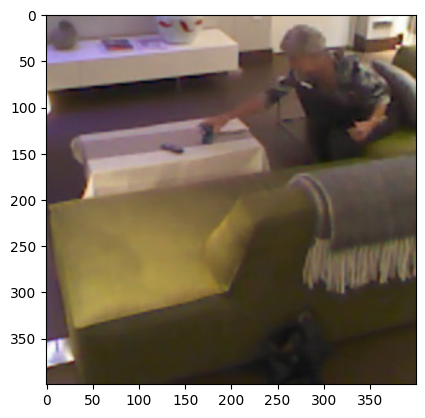

In [127]:
img=cv.resize(c_frames[50],(400,400))
img=cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img)

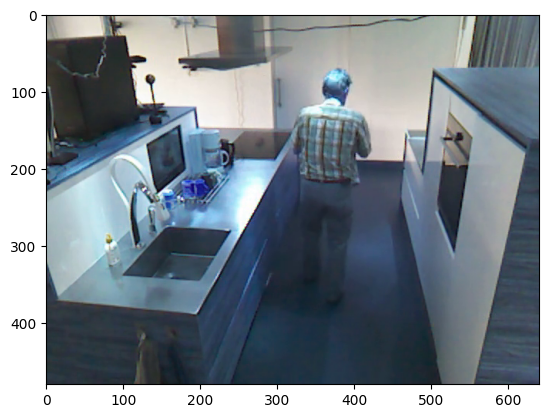

In [26]:
plt.imshow(frames[50])


In [32]:
json_dire=get_json_dire(video_dire)

In [33]:
bbox_info=get_bbox_info(json_dire)

In [34]:
bbox_info

{}

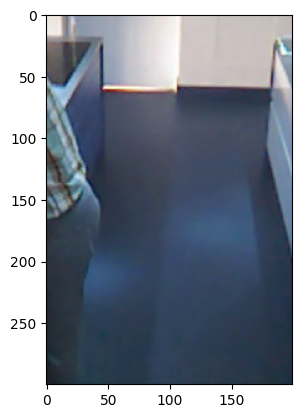

In [27]:
plt.imshow(frames[35])

In [267]:
c_img=crop_img(frame,bbox,300,175)

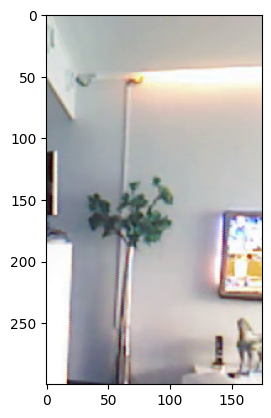

In [268]:
plt.imshow(c_img)

In [261]:
json_dire=get_json_dire(video_dire)

In [278]:
bbox_info=get_bbox_info(json_dire)

In [291]:
test_bbox=dict([i for i in bbox_info.items() if min(i[1])>=0 ])

In [293]:
test_bbox

{0: [188, 177, 122, 134],
 1: [186, 177, 120, 131],
 2: [186, 175, 122, 136],
 3: [185, 173, 109, 126],
 4: [183, 174, 116, 129],
 5: [185, 173, 116, 133],
 6: [184, 171, 118, 134],
 7: [181, 166, 122, 142],
 8: [179, 162, 124, 148],
 9: [180, 160, 122, 154],
 10: [175, 155, 120, 147],
 11: [182, 157, 105, 139],
 12: [184, 152, 119, 160],
 13: [183, 154, 122, 151],
 14: [184, 149, 117, 151],
 15: [186, 152, 115, 147],
 16: [187, 155, 115, 144],
 17: [189, 154, 112, 151],
 18: [185, 149, 118, 152],
 19: [186, 152, 120, 153],
 20: [185, 156, 111, 139],
 21: [185, 153, 117, 148],
 22: [186, 154, 119, 147],
 23: [181, 152, 133, 160],
 24: [170, 155, 145, 157],
 25: [160, 153, 158, 162],
 26: [154, 158, 164, 159],
 27: [154, 152, 169, 171],
 28: [154, 155, 156, 153],
 29: [158, 152, 156, 160],
 30: [154, 158, 153, 146],
 31: [149, 156, 158, 149],
 32: [147, 157, 163, 152],
 33: [135, 154, 178, 158],
 34: [134, 165, 175, 145],
 35: [133, 157, 189, 165],
 36: [134, 156, 181, 158],
 37: [138, 

In [285]:
i[1]

[-9, -14, 373, 368]

In [128]:
a=[1,2,3,4,5,6,7,8,9]

In [130]:
np.math.floor(len(a)*0.9)

8

: 